# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Luc
- Nora
- Kevin
- Thomas
- Zijiang Yang

In [1]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
import time
from io import BytesIO

In [2]:
#NOTE: This takes some time to run (it took me 6 minutes to finish, but it may be faster or slower)

# webscraping
api_key = "03bcc17f7d105b13199e0325b659d4ab"
API_KEY = "6c30ec8965840313bb630941ccabc149"
BASE_URL = "https://api.themoviedb.org/3"

# Function to get movie details by ID
def get_movie_details(movie_id):
    """
    Gets the movie details of a movie through a movie id.

    Args:
        movie_id (string): the id of the movie as a string.

    Returns:
        response: the reponse (as a json) recieved.
    """
    url = f"{BASE_URL}/movie/{movie_id}?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching details for movie ID {movie_id}: {response.status_code}")
        return None

# Function to get movie credits by ID
def get_movie_credits(movie_id):
    """
    Gets the movie credits of a movie through a movie id.

    Args:
        movie_id (string): the id of the movie as a string.

    Returns:
        response: the reponse (as a json) recieved.
    """
    url = f"{BASE_URL}/movie/{movie_id}/credits?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching credits for movie ID {movie_id}: {response.status_code}")
        return None

# Function to get actor popularity by ID
def get_actor_popularity(actor_id):
    """
    Gets the popularity of an actor through an actor id.

    Args:
        actor_id (string): the id of the actor as a string.

    Returns:
        response: the popularity of the actor.
    """
    url = f"{BASE_URL}/person/{actor_id}?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get('popularity')
    else:
      print(f"Error fetching popularity for actor ID {actor_id}: {response.status_code}")
      return None

page = 1
df = pd.DataFrame()
for i in range(50): #the number of pages to go up until
    url = f"{BASE_URL}/movie/top_rated?api_key={api_key}&language=en-US&page={page}"

    response = requests.get(url)
    data = response.json()

    new_data = pd.DataFrame(data['results'])

    df = pd.concat([df, new_data])
    page += 1

# Filter out movies with vote count less than 1000
df = df[df['vote_count'] >= 1000].copy() # Use .copy() to avoid SettingWithCopyWarning

# Add budget information
df['budget'] = None
for index, row in df.iterrows():
    movie_id = row['id']
    details = get_movie_details(movie_id)
    if details and 'budget' in details:
        df.loc[index, 'budget'] = details['budget']
    time.sleep(0.05) # Add a small delay to avoid hitting API limits

# Add top actor popularity
df['top_actor_popularity (out of 10)'] = None # Initialize top_actor_popularity column
for index, row in df.iterrows():
    movie_id = row['id']
    credits = get_movie_credits(movie_id)
    if credits and 'cast' in credits and len(credits['cast']) > 0:
        top_actor_id = credits['cast'][0]['id']
        actor_popularity = get_actor_popularity(top_actor_id)
        df.loc[index, 'top_actor_popularity (out of 10)'] = actor_popularity
    time.sleep(0.05) # Add a small delay to avoid hitting API limits


# Convertin budget to millions n dropping orginal budget column
df['budget_in_millions'] = df['budget'] / 1000000
df = df.drop(columns=['budget'])

df.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,top_actor_popularity (out of 10),budget_in_millions
0,False,/zfbjgQE1uSd9wiPTX4VzsLi0rGG.jpg,"[18, 80]",278,en,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,26.9140,/9cqNxx0GxF0bflZmeSMuL5tnGzr.jpg,1994-09-23,The Shawshank Redemption,False,8.711,29240,1.8322,14.6
1,False,/tmU7GeKVybMWFButWEGl2M4GeiP.jpg,"[18, 80]",238,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",21.8668,/3bhkrj58Vtu7enYsRolD1fZdja1.jpg,1972-03-14,The Godfather,False,8.700,22074,0.5721,0.2
2,False,/kGzFbGhp99zva6oZODW5atUtnqi.jpg,"[18, 80]",240,en,The Godfather Part II,In the continuing saga of the Corleone crime f...,12.9274,/ecBRkXerAZqRRUfR8Lt3L3Dh6J5.jpg,1974-12-20,The Godfather Part II,False,8.571,13340,0.5242,7.275
3,False,/zb6fM1CX41D9rF9hdgclu0peUmy.jpg,"[18, 36, 10752]",424,en,Schindler's List,The true story of how businessman Oskar Schind...,10.2148,/sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg,1993-12-15,Schindler's List,False,8.566,16863,8.3776,178.0
4,False,/w4bTBXcqXc2TUyS5Fc4h67uWbPn.jpg,[18],389,en,12 Angry Men,The defense and the prosecution have rested an...,8.9996,/ow3wq89wM8qd5X7hWKxiRfsFf9C.jpg,1957-04-10,12 Angry Men,False,8.549,9531,0.3246,0.0


In [19]:
#clean data
def get_languages():
    """
    This function gets the list of movie languages from the TMDB.

    Returns:
        response (dict): The list of languages as a dictionary.
    """
    url = "https://api.themoviedb.org/3/configuration/languages"
    params = {"api_key": api_key}
    headers = {"accept": "application/json"}

    response = requests.get(url, headers=headers, params=params)
    return response.json()

def get_movie_genres():
    """
    This funciton gets the list of movie genres from the TMDB.

    Returns:
        response (dict): The list of genres as a dictionary.
    """
    url = "https://api.themoviedb.org/3/genre/movie/list?language=en"
    params = {"api_key": api_key}
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers, params=params)

    return response.json()

def clean_data(df):
    """
    Cleans the data given into these metrics:
        - id
        - title
        - popularity
        - rating
        - number_of_raters
        - top_actor_popularity (out of 10)
        - budget_in_millions
        - release_year
        - release_month
        - release_day
        - original language (as dummy variables in int (1) format)
        - genres (as dummy variables in int (1) format)

    Args:
        df (DataFrame): the inputted dataframe to be cleaned.

    Returns:
        cleaned_df (DataFrame): a cleaned dataframe.
    """

    #get the list of languages from TMDB
    languages_dict = get_languages()
    languages = {}
    for lang in languages_dict:
        languages[lang['iso_639_1']] = lang['english_name']

    #get the list of genres from TMDB
    genres_dict = get_movie_genres()
    genre_list = {}
    for genre in genres_dict['genres']:
        genre_list[genre['id']] = genre['name']

    #initialize lists to hold data
    movie_ids = []
    movie_titles = []
    movie_year = []
    movie_month = []
    movie_day = []
    movie_language = []
    movie_popularity = []
    movie_genres = []
    movie_vote_average = []
    movie_vote_count = []
    movie_budget = []
    movie_top_actor_popularity = []

    #loop through all rows of the data
    for data in df.iterrows():
        movie = data[1]

        movie_ids.append(movie['id']) #append movie id

        movie_titles.append(movie['title']) #append movie title

        #append movie release date
        movie_year.append(int(movie['release_date'][0:4]))
        movie_month.append(int(movie['release_date'][5:7]))
        movie_day.append(int(movie['release_date'][8:10]))

        movie_language.append(languages[movie['original_language']]) #append movie language

        movie_popularity.append(float(movie['popularity'])) #append movie popularity

        #append movie genres as a list of genres
        genres = movie['genre_ids']
        list_of_genres = []
        for index in genres:
            list_of_genres.append(genre_list[index])
        movie_genres.append(list_of_genres)

        #append movie rating average and count
        movie_vote_average.append(float(movie['vote_average']))
        movie_vote_count.append(int(movie['vote_count']))

        movie_budget.append(round(float(movie['budget_in_millions']), 3)) #append movie budget in millions (rounded to 3 decimal places)

        movie_top_actor_popularity.append(movie['top_actor_popularity (out of 10)']) #append top actor popularity

    #put all of the lists into a dictionary
    df_dict = {'movie_id': movie_ids,
               'title': movie_titles,
               'popularity': movie_popularity,
               'rating': movie_vote_average,
               'number_of_raters': movie_vote_count,
               'top_actor_popularity (out of 10)': movie_top_actor_popularity,
               'budget_in_millions': movie_budget,
               'genres': movie_genres,
               'release_year': movie_year,
               'release_month': movie_month,
               'release_day': movie_day,
               'original_language': movie_language,
               }

    cleaned_df = pd.DataFrame(df_dict) #create the dataframe

    #make dummy variables for categorical data
    cleaned_df = pd.get_dummies(cleaned_df, columns=['original_language'], dtype='int')

    df_exploded = cleaned_df.explode('genres') #explode the genres column so each genre has its own row (we'll remove these extra rows later)
    df_genre_dummies = pd.get_dummies(df_exploded['genres']) #get the dummy variables for the genres
    cleaned_df = cleaned_df.join(df_genre_dummies.groupby(df_exploded.index).sum()) #put rows back together again

    cleaned_df = cleaned_df.drop(columns=['genres']) #drop the genres column now, as we don't need it

    cleaned_df = cleaned_df.sort_values(by='movie_id') #sort the dataframe by movie_id (this isn't really necessary)
    return cleaned_df.reset_index(drop=True) #return the dataframe, and reset the index of the rows

    cleaned_df = clean_data(df)
    cleaned_df.head(50)

## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [5]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d

    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """

    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])

    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])

    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [6]:
def line_of_best_fit(X, y):
    """
    Returns a vector containing the cooeficients of the line of best fit

    Args:
        X (array): array of X features
        y (array): array of target features
    Returns:
        m (vector): vector coefficients for the line of best fit
    """
    X = add_bias_column(X)
    XtXinv = np.linalg.inv(np.dot(X.T, X))
    m = np.dot(XtXinv, np.dot(X.T, y))
    return m

In [7]:
def linreg_predict(Xnew, ynew, m):
    """
    Predicts new values based on the line of best fit and returns data based on how well those values were predicted.

    Args:
        Xnew (array): can be either 1-d or 2-d
        ynew (array): 1-d array of target values
        m (vector): values for the line of best fit
    Returns:
        dict: {'ypreds':ypreds, 'resids':resids, 'mse':mse, 'r2':r2}
            ypreds (array): predicted values based on the line of best fit
            resids (array): residuals (ynew - ypreds)
            mse (float): mean squared error
            r2 (float): R-squared value
    """
    Xnew = add_bias_column(Xnew)

    ypreds = np.dot(Xnew, m)

    resids = ynew - ypreds

    mse = np.mean(resids ** 2)

    r2 = r2_score(ynew, ypreds)

    return {'ypreds':ypreds, 'resids':resids, 'mse':mse, 'r2':r2}

### Attempt 1 - Linear Regression

Model 1: Budget vs. Rating
Budget vs. Rating Model - Mean Squared Error: 0.04997739458244657
Budget vs. Rating Model - R2: -0.001314600537893007


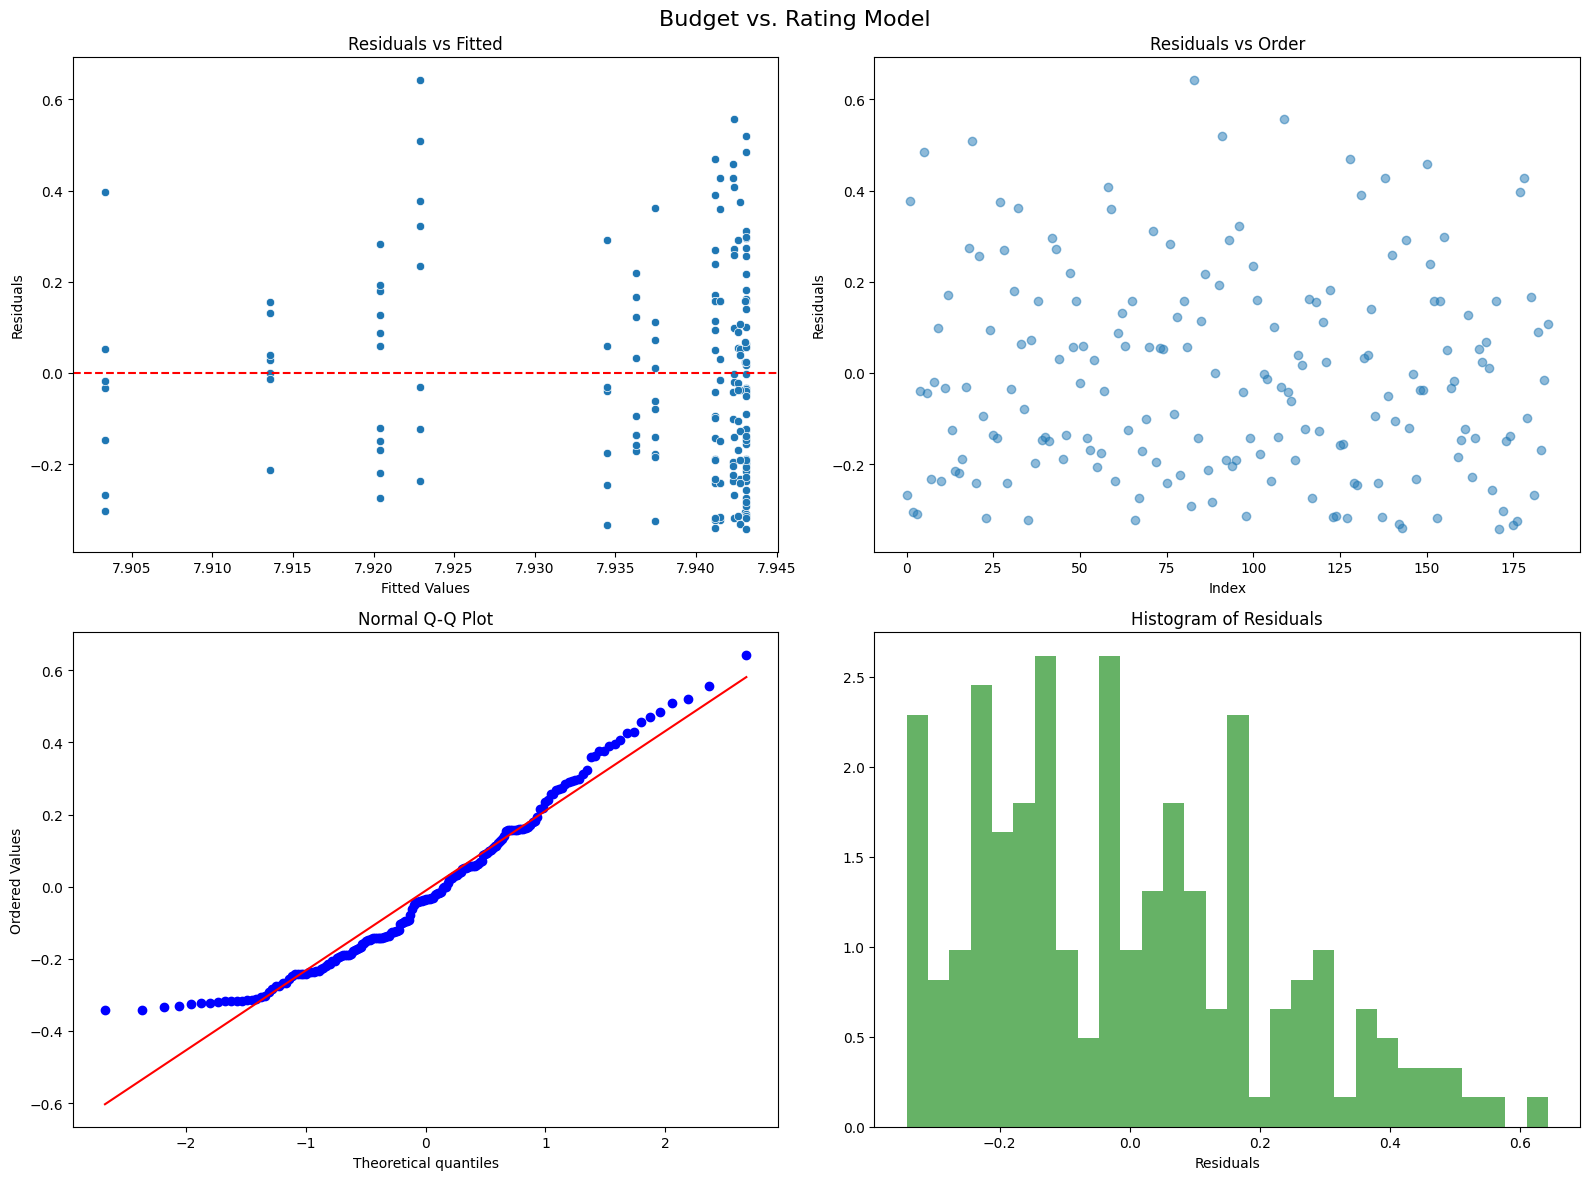


Model 2: Top Actor Popularity vs. Rating
Top Actor Popularity vs. Rating Model - Mean Squared Error: 0.05212164025306526
Top Actor Popularity vs. Rating Model - R2: -0.044275313377548864


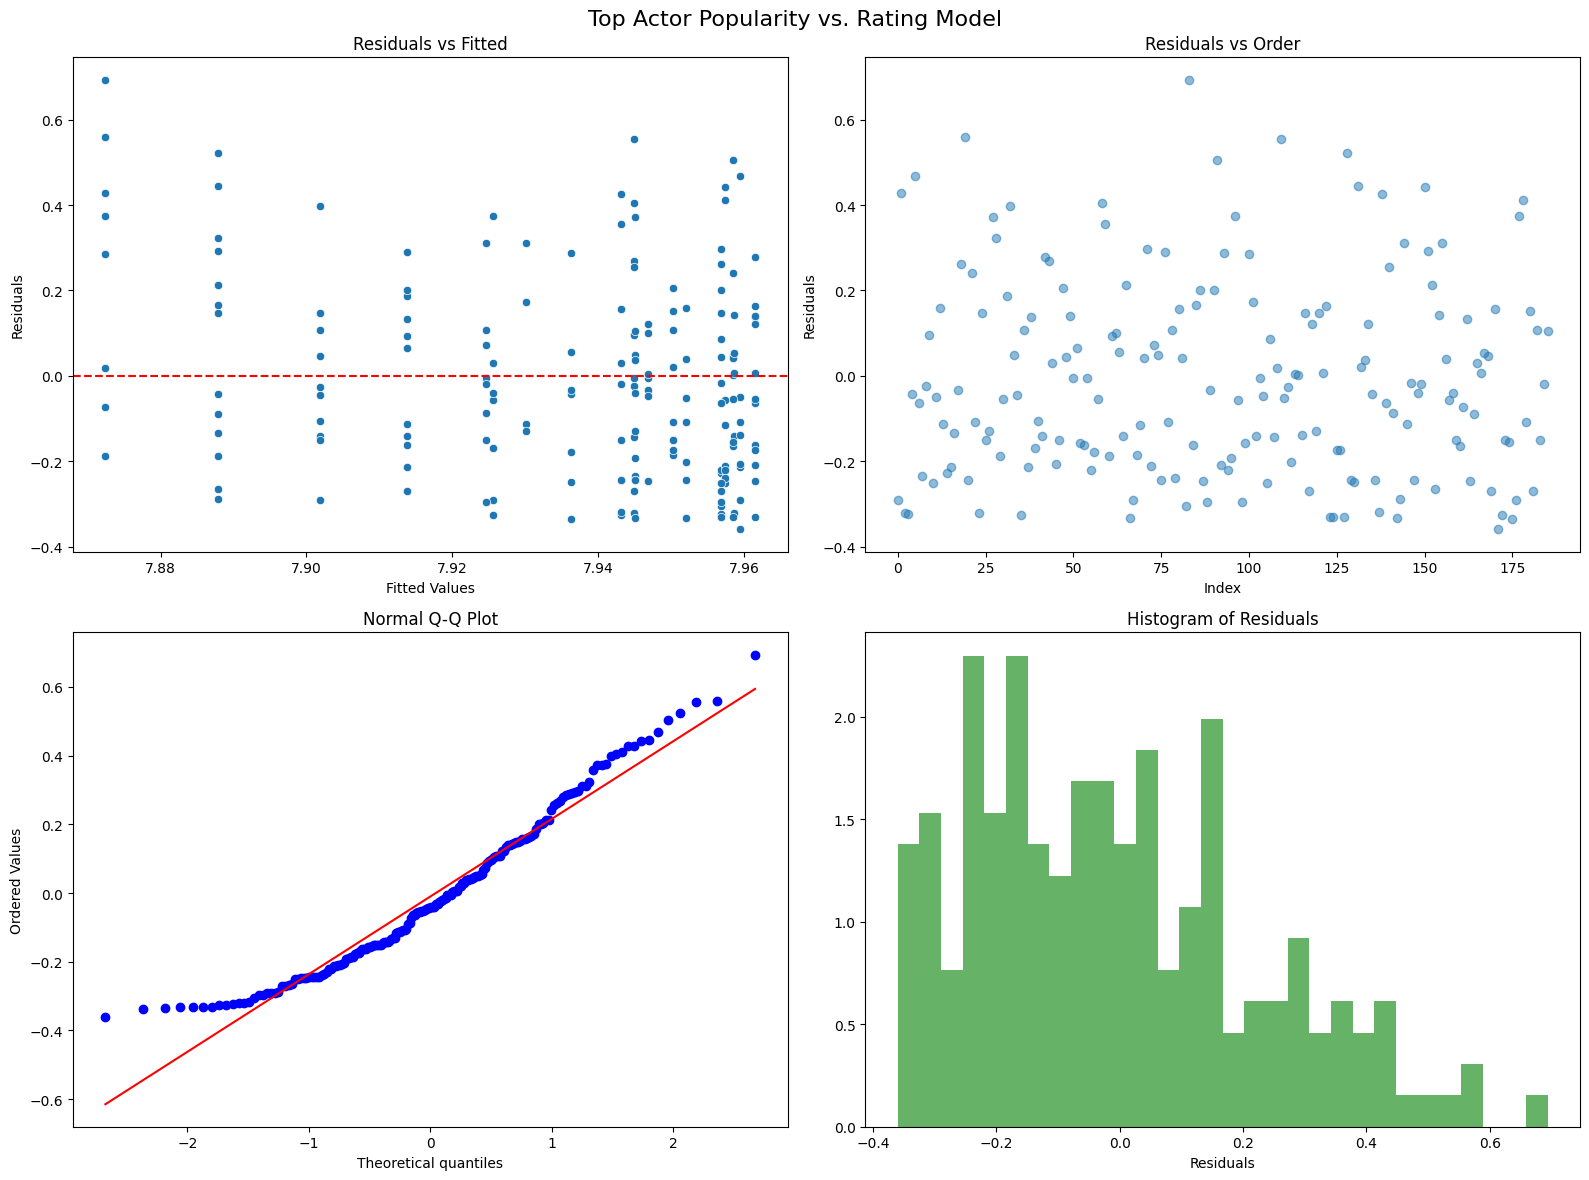


Model 3: Release Year vs. Rating
Release Year vs. Rating Model - Mean Squared Error: 0.04924991053380359
Release Year vs. Rating Model - R2: 0.013260797112397471


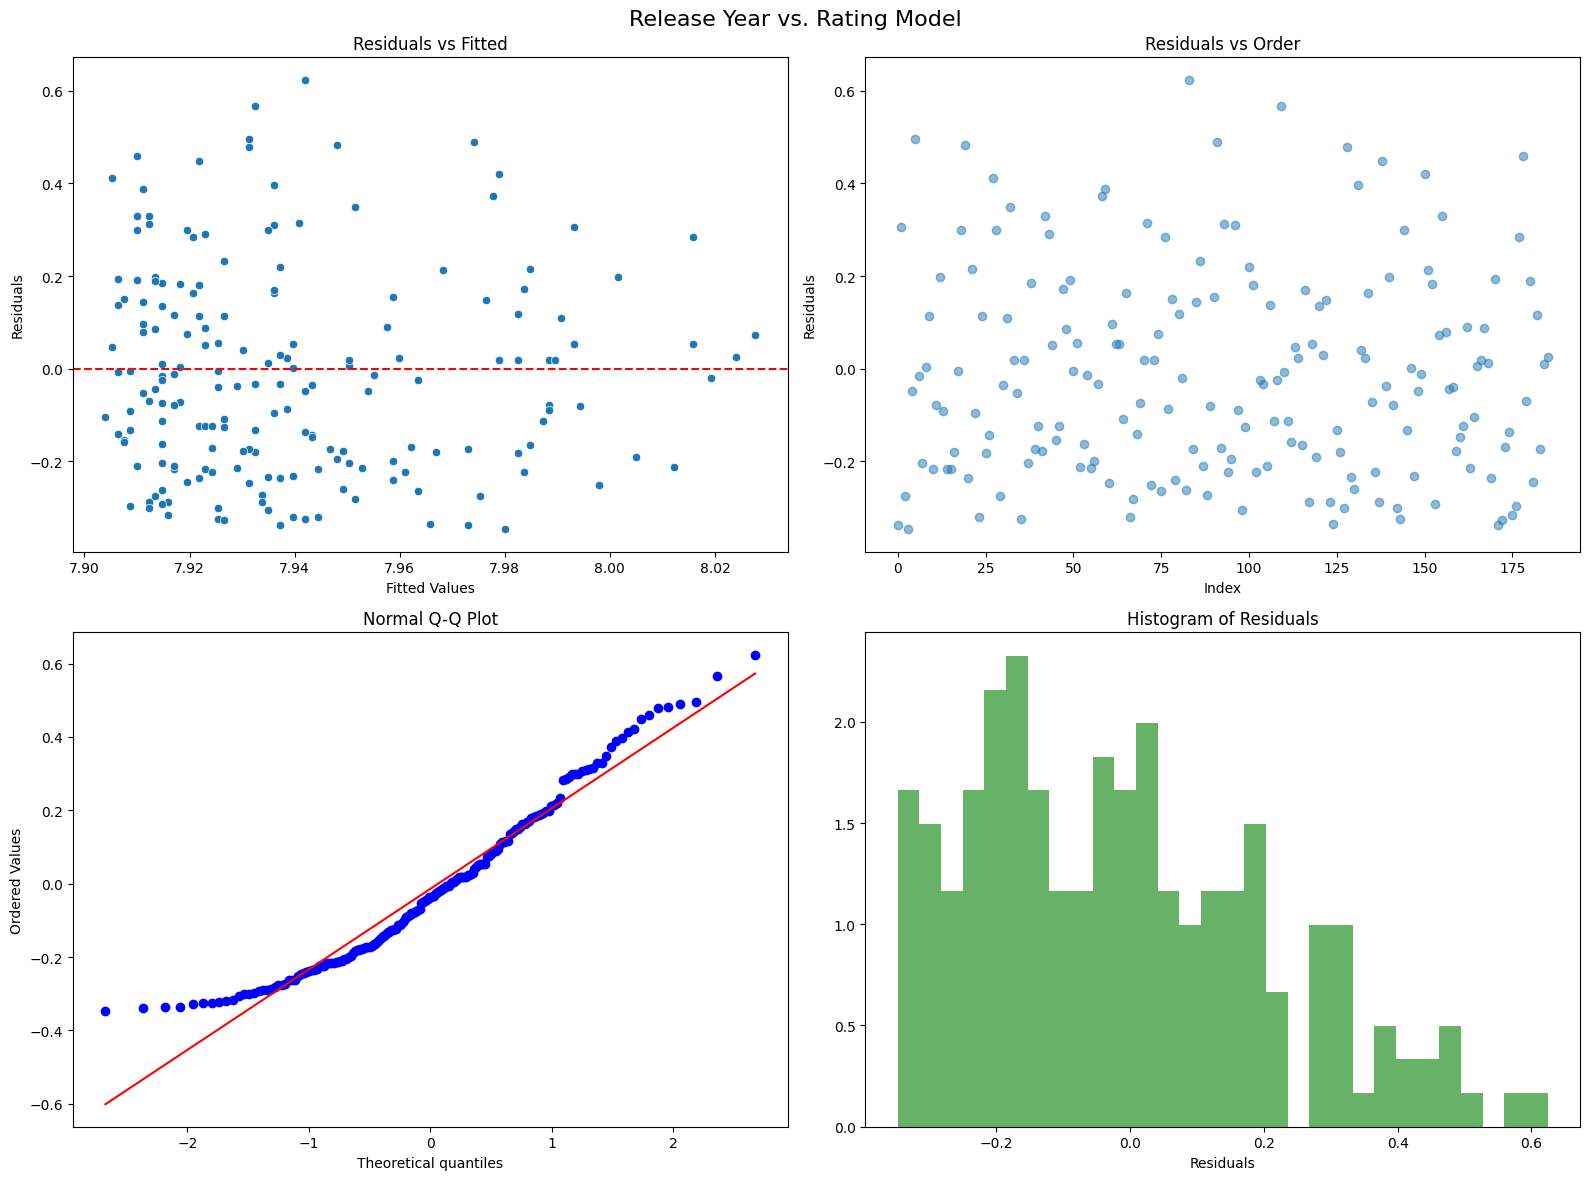


Model 4: Popularity vs. Rating
Popularity vs. Rating Model - Mean Squared Error: 0.04968145677906711
Popularity vs. Rating Model - R2: 0.004614616978360742


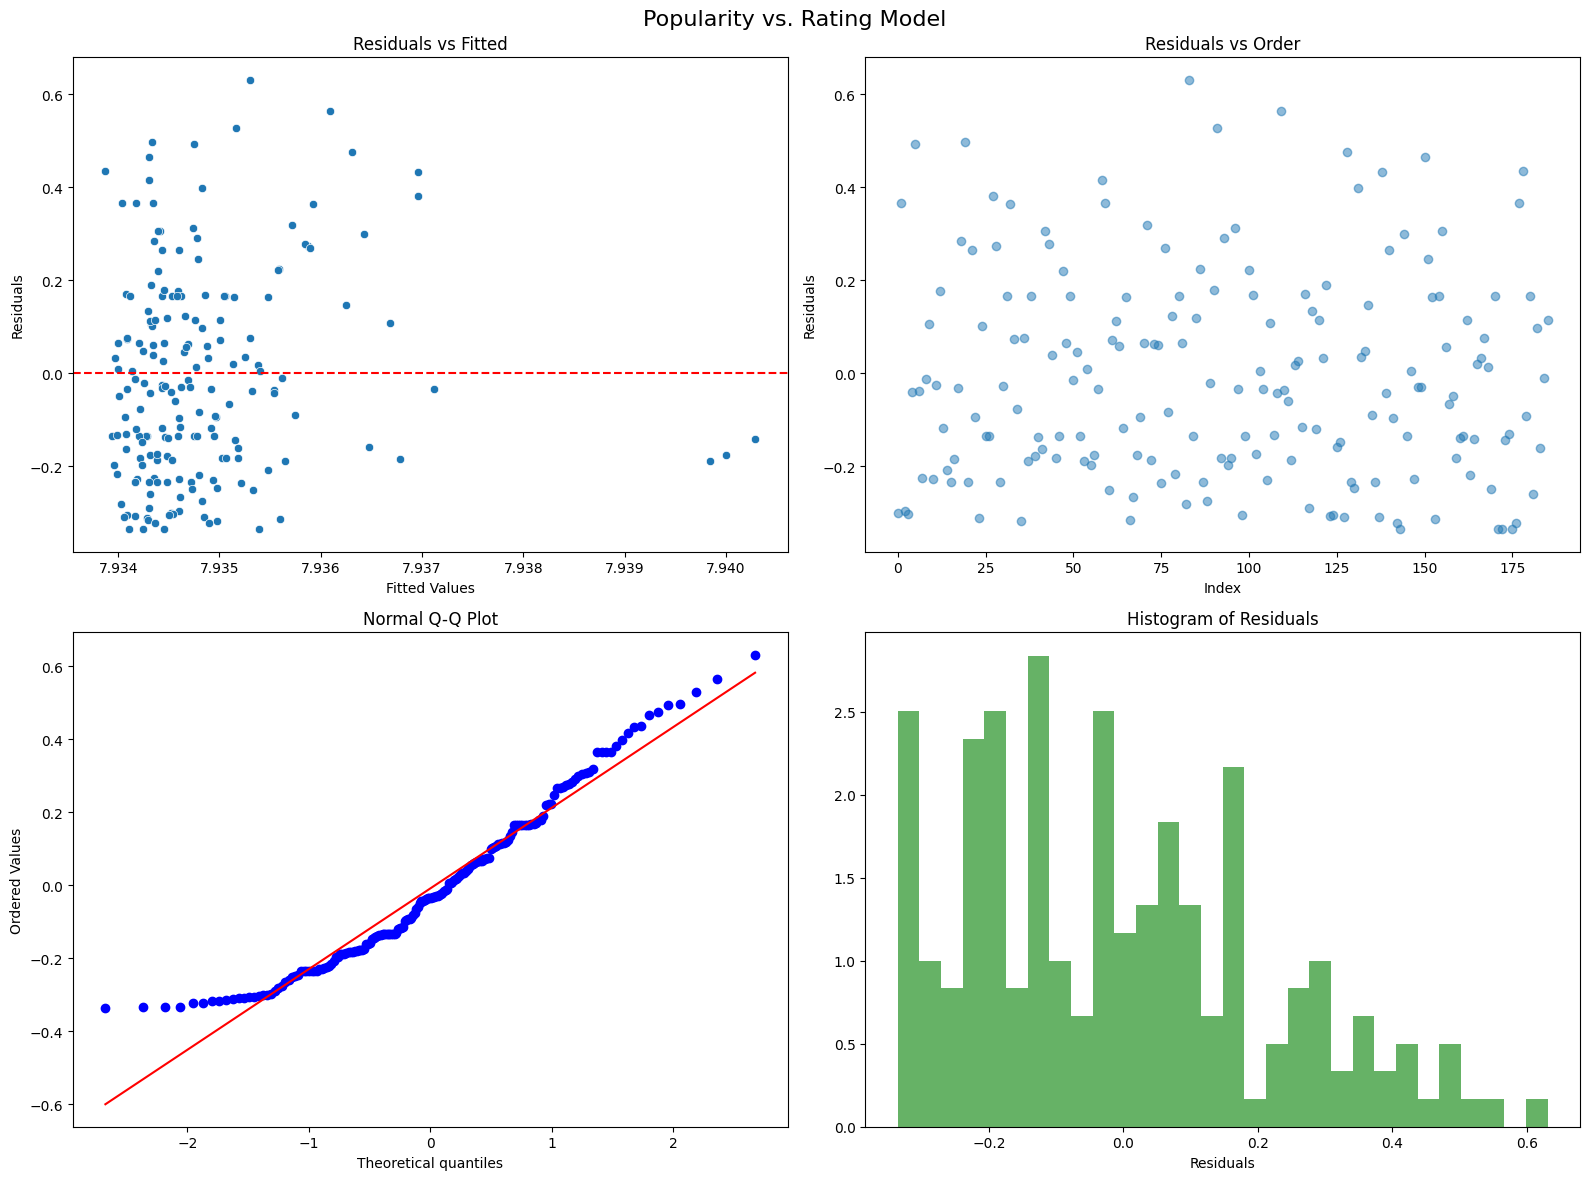


Model 5: Number of Raters vs. Rating
Number of Raters vs. Rating Model - Mean Squared Error: 0.0466315139468408
Number of Raters vs. Rating Model - R2: 0.06572128958963619


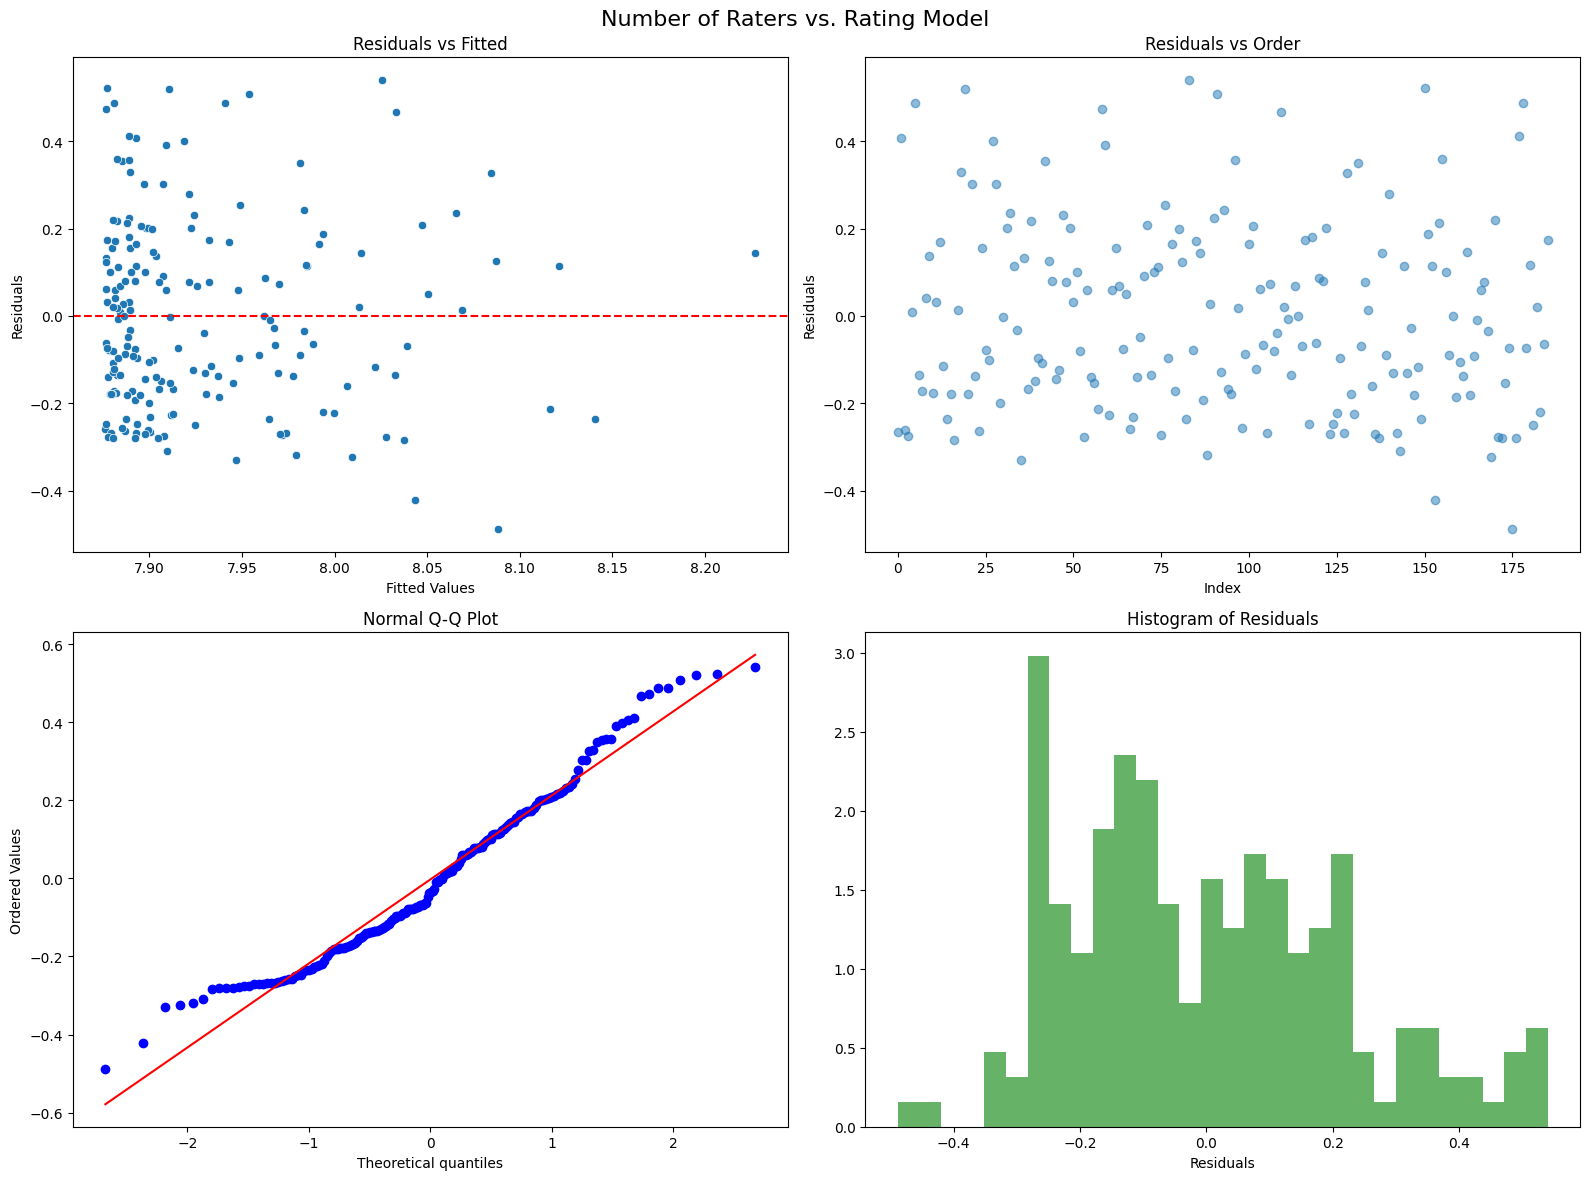


Model 6: Release Month vs. Rating
Release Month vs. Rating Model - Mean Squared Error: 0.04947987094728983
Release Month vs. Rating Model - R2: 0.008653459705289523


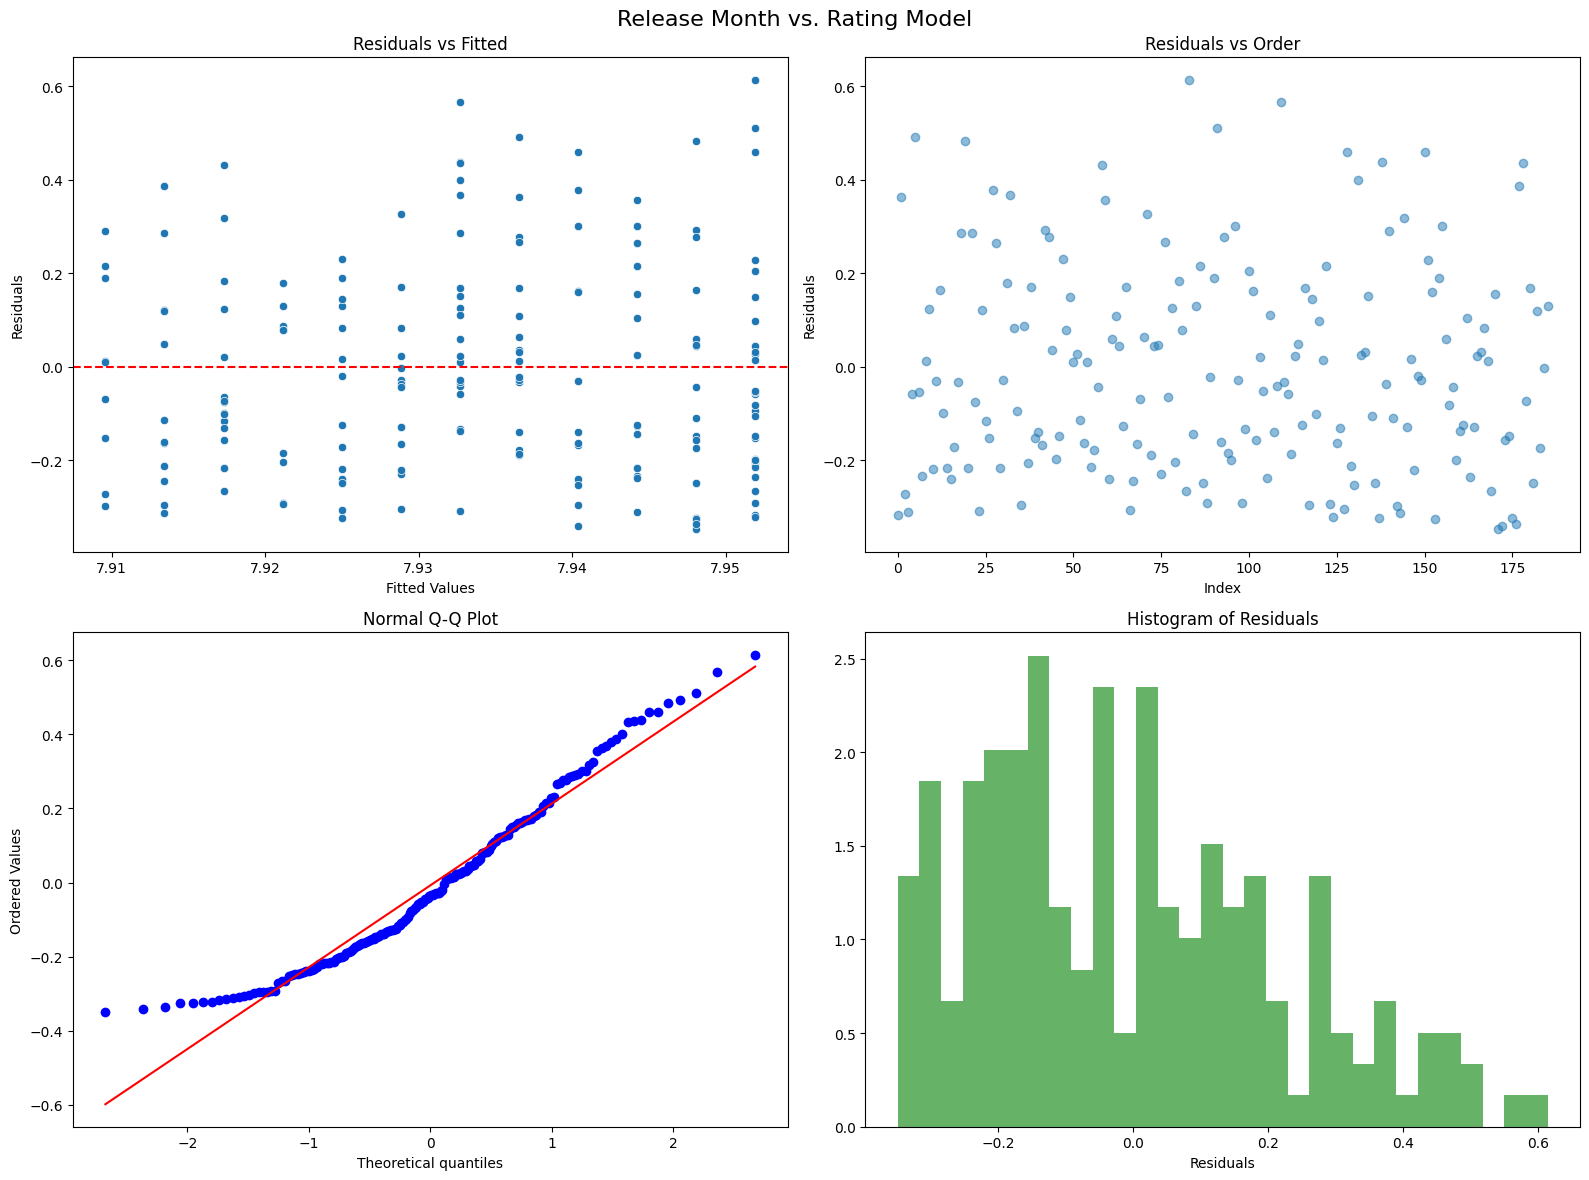

In [23]:
# Function to preprocess the movie data
def preprocess_data(df):
    """
    Preprocess the movie data by keeping only the columns needed
    and ensuring they are numeric.

    Args:
        df (pd.DataFrame): original cleaned_df

    Returns:
        df (pd.DataFrame): preprocessed data ready for ML
    """
    required_columns = [
        'rating',
        'budget_in_millions',
        'top_actor_popularity (out of 10)',
        'release_year',
        'popularity',
        'number_of_raters'
    ]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {', '.join(missing_columns)}")

    # ensure numeric columns are of proper type
    df[['rating', 'budget_in_millions', 'top_actor_popularity (out of 10)', 'release_year', 'popularity', 'number_of_raters']] = df[
        ['rating', 'budget_in_millions', 'top_actor_popularity (out of 10)', 'release_year', 'popularity', 'number_of_raters']].apply(pd.to_numeric, errors='coerce')
    df.dropna(subset=['rating', 'budget_in_millions', 'top_actor_popularity (out of 10)', 'release_year', 'popularity', 'number_of_raters'], inplace=True)

    return df


# Function to fit and evaluate the model
def evaluate_model(X, y, title):
    """
    Fit a linear regression model and check assumptions with diagnostic plots.

    Args:
        X (array): array with x feature values
        y (array): array with y values
        title (str): title of the model for the graph

    Returns:
         An evaluated model for the given feature along with the plots
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {mse}")
    r2 = 1 - (mse / y_test.var())
    print(f"{title} - R2: {r2}")


    # Residuals
    residuals = y_test - y_pred

    # Diagnostic Plots
    plt.figure(figsize=(16, 12))

    # 1. Residuals vs Fitted
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # 2. Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(X_test)), residuals, alpha=0.5)
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Order")

    # 3. Q-Q Plot
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')

    # 4. Histogram of Residuals
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Main function to answer the question
def main():
    """
    Returns:
        Evaluated models for each feature along with the graphs
    """
    df = preprocess_data(cleaned_df)

    # budget vs rating
    print("Model 1: Budget vs. Rating")
    X_budget = df[['budget_in_millions']]
    y = df['rating']
    evaluate_model(X_budget, y, "Budget vs. Rating Model")

    # top actor popularity vs rating
    print("\nModel 2: Top Actor Popularity vs. Rating")
    X_actor = df[['top_actor_popularity (out of 10)']]
    evaluate_model(X_actor, y, "Top Actor Popularity vs. Rating Model")

    # release year vs rating
    print("\nModel 3: Release Year vs. Rating")
    X_year = df[['release_year']]
    evaluate_model(X_year, y, "Release Year vs. Rating Model")

    # popularity vs rating
    print("\nModel 4: Popularity vs. Rating")
    X_pop = df[['popularity']]
    evaluate_model(X_pop, y, "Popularity vs. Rating Model")

    # num of raters vs rating
    print("\nModel 5: Number of Raters vs. Rating")
    X_raters = df[['number_of_raters']]
    evaluate_model(X_raters, y, "Number of Raters vs. Rating Model")

    print("\nModel 6: Release Month vs. Rating")
    X_month = df[['release_month']]
    evaluate_model(X_month, y, "Release Month vs. Rating Model")

# Run the main function
if __name__ == '__main__':
    main()

### Polynomial regression

Using the X features of top_actor_popularity, budget_in_millions, and release_month to create a model that determines the popularity of a movie. This model uses a polynomial with a degree of 2.

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
list_of_features = []

columns_to_include = ['top_actor_popularity (out of 10)', 'budget_in_millions', 'release_month']
for column in columns_to_include:
    list_of_features.append(column)

X = np.array(cleaned_df[list_of_features])
y = cleaned_df['popularity']

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
X_poly = X_poly[:, 1:] #gets rid of the columns of 1s

Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, y, test_size=0.3) # 30% test, 70% train

# fit model
m = line_of_best_fit(Xtrain, ytrain)
poly_model = linreg_predict(Xtest, ytest, m)

print("Line of best fit: ", m)
print("MSE of polynomial model: ", poly_model['mse'])
print("R2 of polynomial model: ", poly_model['r2'])

Line of best fit:  [10.23449876 -2.04519345  0.20851704  0.98735621  0.72983217 -0.29564374
 -1.05972356 -0.19322772 -0.51134549 -1.18329449]
MSE of polynomial model:  49.82860401183683
R2 of polynomial model:  -0.22184604770846494


### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

In [15]:
# X and y selection
numeric_cols = ['top_actor_popularity (out of 10)', 'budget_in_millions', 'release_month',
                'number_of_raters', 'release_year']

genre_cols = [col for col in cleaned_df.columns if col in ['History','Horror','Music','Mystery',
                                                          'Romance','Science Fiction','TV Movie',
                                                          'Thriller','War','Western']]

lang_cols = [col for col in cleaned_df.columns if col.startswith('original_language')]

columns_to_include = numeric_cols + genre_cols + lang_cols

X = cleaned_df[columns_to_include].copy()  # Make a copy to be safe
y = cleaned_df['popularity']

# Scale columns
scaler = StandardScaler()
X_scaled_numeric = pd.DataFrame(
    scaler.fit_transform(X[numeric_cols]),
    columns=numeric_cols,
    index=X.index
)

# Replace numeric columns in X with scaled values
X[numeric_cols] = X_scaled_numeric

# polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# lin reg
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)

MSE: 416.89102877397295
R²: 0.4955653733645399


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

***Initial Approach :***

Our objective was to explore whether various movie-related predictors explain variation in IMDb ratings. To do this we constructed six separate simple linear regression models—one for each feature. (Budget, Top Actor Popularity, Release Year, Popularity, Number of Raters, and Release Month) For each model, we evaluated performance using MSE, R^2, and full diagnostic residual plots (Residuals vs Fitted, Residuals vs Order, Histogram, and Q-Q plot). These preliminary results allow us to check whether assumptions are met and whether linearity is an appropriate modeling approach.



***Model 1: Budget vs. Rating***

This model produced MSE = 0.04998 and R² = –0.00131, indicating almost no explanatory power.

From the Residuals vs Fitted plot, the points show no clear linear trend, and the fitted values are extremely narrow (around 7.91–7.94). The vertical clustering suggests that Budget does not meaningfully change the fitted rating values. Variance looks slightly uneven, so the constant variance assumption is somewhat questionable.

The Residuals vs Order plot shows random scatter with no obvious trend, which gives some weak support for independence, though there are small clusters in a few regions.

The Normal Q–Q plot shows noticeable deviation from the diagonal line at both tails. This suggests non-normality, especially because the upper tail bends away from the theoretical line.

The Histogram of residuals also shows a mild right skew, matching the Q–Q plot’s pattern.

Overall, this model shows no meaningful linear relationship between Budget and Rating, and several assumptions are slightly strained.



***Model 2: Top Actor Popularity vs. Rating***

This model produced MSE = 0.05212 and R² = –0.04427, which again shows almost no explanatory value and slightly worse fit than Model 1.

The Residuals vs Fitted plot shows vertical banding similar to Model 1, where fitted values stay extremely close together (7.88–7.96). There is no clear linear pattern, suggesting that Top Actor Popularity does not linearly influence ratings. The scatter appears uneven in some areas, hinting at minor heteroscedasticity.

In the Residuals vs Order plot, the points are randomly spread without obvious structure. This supports independence, though a few denser clusters indicate that independence may not fully hold.

The Normal Q–Q plot again shows deviations at the upper tail, bending above the diagonal line, indicating non-normal residuals. This matches the Histogram, which shows slight right skew.

Overall, Top Actor Popularity does not show a reliable linear relationship with IMDb rating, and assumptions are mildly violated.



***Model 3: Release Year vs. Rating***

This model produced MSE = 0.04925 and R² = 0.01326, the first model with a slightly positive R², but still extremely weak.

The Residuals vs Fitted plot again shows almost no spread in fitted values (around 7.90–8.02), along with uneven clustering. This suggests no linear trend and mild violations of constant variance.

The Residuals vs Order plot shows fairly random scatter with no strong trend, which weakly supports independence.

The Q–Q plot shows noticeable deviations, especially in the upper tail, similar to prior models. The Histogram also suggests mild right skew.

While this model performs slightly better than the previous two, Release Year still shows very limited linear relationship with rating.

***Model 4: Popularity vs. Rating***

This model yielded MSE = 0.04968 and R² = 0.00446, showing almost no predictive power.

The Residuals vs Fitted plot reveals strong vertical clustering around very narrow fitted values (7.934–7.940), showing no linear relationship. Variance is uneven near the lower fitted values, which suggests a violation of linearity and constant variance assumptions.

The Residuals vs Order plot looks mostly random but still contains pockets of dense clustering. Independence is not strongly violated but is not perfectly satisfied either.

The Q–Q plot and Histogram both show mild right skew with tail deviations from normality, similar to earlier models.

Overall, Popularity does not provide meaningful linear predictive value for IMDb ratings.

***Model 5: Number of Raters vs. Rating***

This model performed the best among all six models, with MSE = 0.04663 and R² = 0.06572. Although this is the highest R² so far, the predictive power is still weak.

The Residuals vs Fitted plot shows slightly more spread in fitted values compared to other models, but still no clear linear trend. Variance appears somewhat uneven, suggesting mild heteroscedasticity.

The Residuals vs Order plot shows random scatter with no noticeable trend, giving the strongest support for independence among all models.

The Q–Q plot shows smaller deviations than the earlier models but still bends at the upper tail. The Histogram also suggests mild skewness.

Overall, this model meets assumptions better than the others but still only explains a small fraction of rating variation.

***Model 6: Release Month vs. Rating***

This model yielded MSE = 0.04948 and R² = 0.00887, showing very weak explanatory value.

The Residuals vs Fitted plot shows vertical striping since Release Month is a discrete variable (1–12). This indicates that a simple linear regression is not ideal for a categorical-like predictor. There is no linear trend, and variance differs across strips.

The Residuals vs Order plot shows random scatter with mild clustering, suggesting partial independence but not perfect.

The Q–Q plot again shows tail deviations from the diagonal line, and the Histogram shows a slight right skew.

Overall, Release Month provides very little predictive power and is not well-suited for simple linear regression.

***In conclusion***

Across all six simple linear regression models, none of the predictors demonstrated strong linear relationships with IMDb ratings. The best-performing predictor was Number of Raters (Model 5), with the lowest MSE (0.04663) and the highest R² (0.06572). However, even this model only explains around 6.5% of the variance in ratings, which is extremely low.

All other models produced near-zero or negative R² values, confirming that single-variable linear models are not effective for predicting IMDb ratings. The residual diagnostics consistently showed:

No clear linear trend

Uneven variance (heteroscedasticity)

Clusters in residual order plots (partial independence issues)

Right-skewed residuals and Q–Q tail deviation (normality violations)

These issues indicate that IMDb ratings likely depend on complex, multi-dimensional factors that cannot be captured using any single quantitative predictor from this dataset.

Future research directions may include:

Multivariate models combining multiple predictors simultaneously

Nonlinear models or interaction terms

Including additional features such as genre, text review sentiment, director/actor reputation, or dummy variables for categories

These approaches may better capture the complex relationships that influence movie ratings.

